<span>
<img src="https://cdlib.readthedocs.io/en/latest/_static/cdlogo.png" width="260px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.7<br/>
<b>NDlib version:</b>  0.1.2<br/>
<b>Last update:</b> 6/03/2019
</span>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

<a id='top'></a>
# *Intro to CDlib: Community Discovery library*

``CDlib`` is a python library designed to provide support the extraction and analysis of network clusterings.

In this notebook are introduced some of the main features of the library and an overview of its functionalities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available, please refer to the official [documentation](https://cdlib.readthedocs.io).

## Table of Contents

1. [Installing CDlib](#install)
2. [Community Discovery Workflow](#workflow)
    1. [Graph Creation](#graph)
    2. [Community Discovery algorithm(s) selection and configuration ](#model)
    3. [Clustering Evaluation (Fitness functions)](#fitness)
    4. [Clustering Evaluation (Comparison)](#comparison)
    5. [Community/Statistics Visualization](#visualization)
3. [Advanced facilities: Pooling and Optimization](#advanced)
    1. [Pooling](#pooling)
    2. [Optimization](#optimization)
4. [Conclusions](#conclusion)

<a id='install'></a>
## 1. Installing CDlib ([to top](#top))

As a first step, we need to make sure that ``CDlib`` is installed and working.

The library is available for python 3.7, and its stable version can be installed using ``pip``:

    pip install cdlib

On the project [GitHub](https://github.com/GiulioRossetti/cdlib) are also available the nightly builds that can be installed as follows:

    pip install git+https://github.com/GiulioRossetti/ndlib.git > /dev/null

In order to check if ``cdlib`` has been correctly installed just try to import it

In [1]:
import cdlib

<a id='workflow'></a>
## 2. Community Discovery Workflow ([to top](#top))

``CDlib`` allows to extract, analyze and compare network clustering applying several approaches.
The standard workflow can be summarized as:
- Network Creation
- Community Discovery algorithm(s) selection and configuration
- Clustering(s) evaluation (Fitness functions)
- Clustering(s) evaluation (Comparisons)
- Community/Statistics Visualization

In this section we will observe how to templating such workflow applying two classic network clustering algorithms: Label Propagation and Leiden.

<a id="graph"></a>
### 2.A Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``CDlib`` natively supports both [``networkx``](https://networkx.github.io) and [``igraph``](https://igraph.org/python/) data structures.

In our examples, for the sake of simplicity, we will use ``networkx`` undirected graphs. 

In [2]:
import networkx as nx

g = nx.karate_club_graph()

<a id="model"></a>
### 2.B Community Discovery algorithm(s) selection and configuration ([to top](#top))

After having defined the graph, we can select the algorithm(s) to partition it.

In [3]:
from cdlib import algorithms

In [4]:
lp_coms = algorithms.label_propagation(g)

In [5]:
leiden_coms = algorithms.leiden(g)

All Community Discovery algorithms generate as result an object that implements a concrete instance of the ``Clustering`` datatype.

In particular, both Louvain and Label Propagation returns a ``NodeClustering`` object having the following propterties:

In [6]:
leiden_coms.method_name # Clustering algorithm name

'Leiden'

In [7]:
leiden_coms.method_parameters # Clustering parameters

{'initial_membership': None, 'weights': None}

In [8]:
leiden_coms.communities # Identified Clustering

[[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
 [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [23, 24, 25, 27, 28, 31],
 [4, 5, 6, 10, 16]]

In [9]:
leiden_coms.overlap # Wehter the clustering is overlapping or not

False

In [10]:
leiden_coms.node_coverage # Percentage of nodes covered by the clustering

1.0

Moreover, ``Clustering`` object allow also for the generation of a JSON representation of the results

In [11]:
leiden_coms.to_json()

'{"communities": [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [23, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16]], "algorithm": "Leiden", "params": {"initial_membership": null, "weights": null}, "overlap": false, "coverage": 1.0}'

<a id="fitness"></a>
### 2.C Clustering Evaluation (Fitness functions) ([to top](#top))

After having obtained a network clustering we can compute several indexes upon it. 

For a same index it is possible to obtain a synthetic representation of its min/max/mean/std values

In [12]:
leiden_coms.average_internal_degree()

FitnessResult(min=2.3333333333333335, max=4.181818181818182, score=3.103787878787879, std=0.7758948002447444)

as well as its communitiy-wise value

In [13]:
leiden_coms.average_internal_degree(summary=False)

[3.5, 4.181818181818182, 2.3333333333333335, 2.4]

Fitness scores can also be instantiated at library level

In [14]:
from cdlib import evaluation

evaluation.average_internal_degree(g, leiden_coms)

FitnessResult(min=2.3333333333333335, max=4.181818181818182, score=3.103787878787879, std=0.7758948002447444)

For the complete list of implemented fitness functions, refer to the online [documentation](https://cdlib.readthedocs.io/en/latest/reference/evaluation.html).

<a id="comparison"></a>
### 2.D Clustering Evaluation (Comparison) ([to top](#top))

When multiple clustering have been computed on a same network it is useful to measure their resemblance.

``CDlib`` allows to do so by exposing several clustering resemblance scores, each one of them tailored to support specific kind of network clusterings (crisp/partition, complete/partial node coverage).

As for the fitness functions, resemblance scores can be instantiated at the community level as well as at the library level.

In [15]:
leiden_coms.normalized_mutual_information(lp_coms)

MatchingResult(score=0.5421597004371672, std=None)

In [16]:
evaluation.normalized_mutual_information(leiden_coms, lp_coms)

MatchingResult(score=0.5421597004371672, std=None)

<a id="visualization"></a>
### 2.E Community/Statistics Visualization ([to top](#top))

``CDlib`` allows to generate two families of predefined plots:
- network/community visualizations
- community fitness/comparison visualizations

#### 2.E.1 Graph visualization

One way to visualize the communities identified on a graph is by coloring graph nodes accordingly

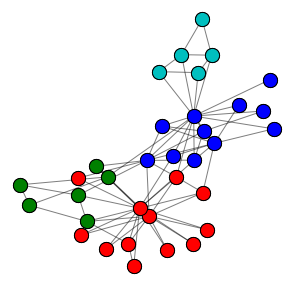

In [17]:
from cdlib import viz

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, leiden_coms, pos, figsize=(5, 5))

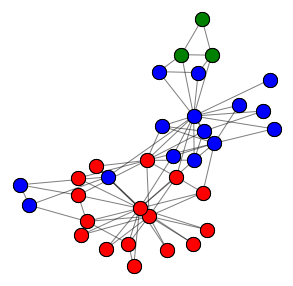

In [18]:
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5))

Such strategy is feasible when the network is small enogh. In case of medium size graphs an alternative is collapsing all community nodes into a single met-node and visualize the resulting community graph:

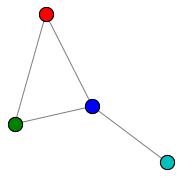

In [19]:
viz.plot_community_graph(g, leiden_coms, figsize=(3, 3))

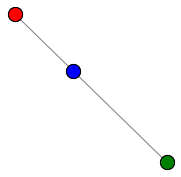

In [20]:
viz.plot_community_graph(g, lp_coms, figsize=(3, 3))

#### 2.E.2 Community fitness/comparison visualization

Given one (or more) clustering it could be useful to visualize how a given fitness function distributes over the communities.

A nice way to do so is by using violin plots.

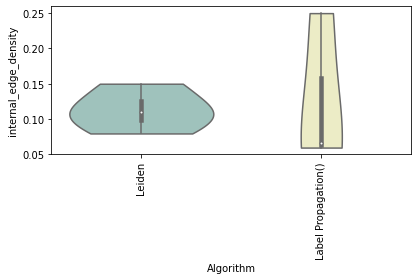

In [21]:
viz.plot_com_stat([leiden_coms, lp_coms], evaluation.internal_edge_density)

Another simple visualization type that allows getting a few insights on community characteristics is the scatter plot.

We can easily pair-wise compare fitness functions for one or more clustering as follows:

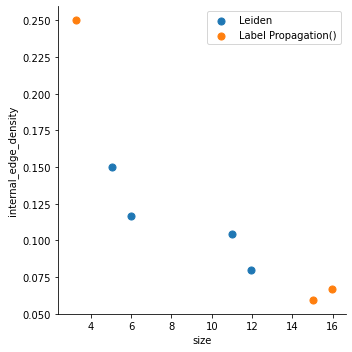

In [22]:
viz.plot_com_properties_relation([leiden_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)

Let assume we want to compare different clusterings over a set of network ground truth partitions.

In order to obtain a more interesting example, we can generate a few synthetic graphs with planted ground truth clusterings and perform CD upon them. <br/> We can easily visually compare their resuls as follows:

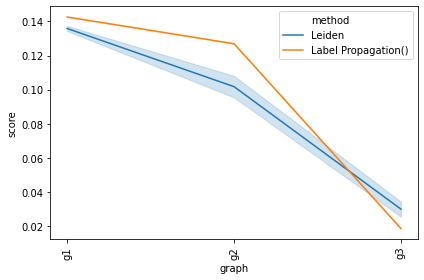

In [24]:
from cdlib import NodeClustering

g1 = nx.generators.community.LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = nx.generators.community.LFR_benchmark_graph(1000, 3, 1.5, 0.6, min_community=20, average_degree=5)
g3 = nx.generators.community.LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)

names = ["g1", "g2", "g3"]
graphs = [g1, g2, g3]
references = []

# building the NodeClustering ground truth for the graphs
for g in graphs:
    ground_truth = NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference")
    references.append(ground_truth)
    
algos = [algorithms.leiden, algorithms.label_propagation]

# Computing the visualization (2 execution per method, NMI as scoring for ground truth resemblance)
viz.plot_scoring(graphs, references, names, algos, scoring=evaluation.adjusted_mutual_information, nbRuns=2)

Finally, we can also compare different clustering obtained on the same graph by alternative algorithms among them. <br/>
Let's get back to our initial Karate Club graph and compute a few more clusterings upon it:

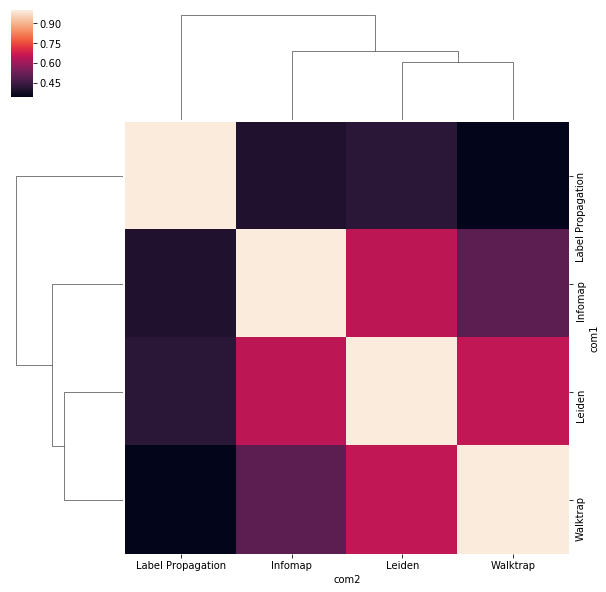

In [ ]:
g = nx.karate_club_graph()

lp_coms = algorithms.label_propagation(g)
leiden_coms = algorithms.leiden(g)
wp_coms = algorithms.walktrap(g)
infomap_coms = algorithms.infomap(g)

viz.plot_sim_matrix([leiden_coms, lp_coms, wp_coms, infomap_coms],evaluation.adjusted_mutual_information)

<a id='advanced'></a>
## 3. Advanced facilities: Pooling and Optimization ([to top](#top))

``CDlib`` offers a few facilities out-of-the-box to automate the execution of multiple CD approaches over a same graph.

The offered facilities can be broadly grouped into two subclasses:
- Pooling, and
- Optimization


<a id='pooling'></a>
### 3.A Pooling

Pooling allows to stack the execution of multiple algorithms

In [ ]:
from cdlib import ensemble

# Louvain configuration
methods = [algorithms.louvain, algorithms.leiden]

for coms in ensemble.pool(g, methods, configurations=[[], []]):
    print(coms.method_name, "\n", coms.communities)

Louvain 
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)]
Leiden 
 [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [23, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16]]


The ``configuration`` parameter allows to define a list of parameters for each algorithm. <br/>
Each list must contains only instances of either ``Parameter`` or ``BoolParameter`` namedtuples.

In [ ]:
# Example of Louvain configuration
resolution = ensemble.Parameter(name="resolution", start=0.1)
randomize = ensemble.BoolParameter(name="randomize", value=True)
louvain_conf = [resolution, randomize]

methods = [algorithms.louvain, algorithms.leiden]

for communities in ensemble.pool(g, methods, [louvain_conf, []]):
    print(coms.method_name, "\n", coms.communities)

Leiden 
 [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [23, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16]]
Leiden 
 [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [23, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16]]


``Parameter`` and ``BoolParameter`` allows to define also grid ranges, for instance:

In [ ]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1) # numeric range
randomize = ensemble.BoolParameter(name="randomize") # boolean range [True, False]

Such generalization allows for their use into another pooling facility: Grid Execution.

Grid Execution takes care to instantiate a CD algorithm with all the possible combination of parameter values (cartesian product) as expressed by the ranges passed as input.

In [ ]:
resolution = ensemble.Parameter(name="resolution", start=0.7, end=1, step=0.1)

for coms in ensemble.grid_execution(graph=g, method=algorithms.louvain, parameters=[resolution]):
    print(coms.method_name, coms.method_parameters, "\n", coms.communities, "\n")

Louvain {'weight': 'weight', 'resolution': 0.7, 'randomize': False} 
 [(0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (8, 14, 15, 18, 20, 22, 30, 32, 33), (4, 5, 6, 10, 16), (23, 26, 27, 29), (24, 25, 28, 31)] 

Louvain {'weight': 'weight', 'resolution': 0.7999999999999999, 'randomize': False} 
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 

Louvain {'weight': 'weight', 'resolution': 0.8999999999999999, 'randomize': False} 
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 

Louvain {'weight': 'weight', 'resolution': 0.9999999999999999, 'randomize': False} 
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 



<a id='optimization'></a>
### 3.A Optimization

Often it make sense to execute a given CD algorithm multiple times, varying its parameters, so to identify the optimal configuration w.r.t. a given fitness score.

The esiest way to do so is by performing a grid search:

In [ ]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")

coms, scoring = ensemble.grid_search(graph=g, method=algorithms.louvain,
                                                     parameters=[resolution, randomize],
                                                     quality_score=evaluation.erdos_renyi_modularity,
                                                     aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms.communities, coms.method_parameters, scoring))

Communities:
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 
Configuration: {'weight': 'weight', 'resolution': 0.8, 'randomize': True} 
Scoring: 0.4712052653229123


Grid search will execute **all** the possible configuration as expressed by the method parameters and return only the optimal partition w.r.t. the specified fitness function (ER modularity in our example) and aggregation function (we want to maximize the fitness score).

Indeed, such strategy could be costly. <br/>
For this reason ``CDlib`` aslo implements a random search optimization strategy that reduces the number of method instantiation over the configuration grids (controlling it through the ``instance`` parameter value).

In [ ]:
communities, scoring = ensemble.random_search(graph=g, method=algorithms.louvain,
                                                       parameters=[resolution, randomize],
                                                       quality_score=evaluation.erdos_renyi_modularity,
                                                       instances=5, aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms.communities, coms.method_parameters, scoring))

Communities:
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 
Configuration: {'weight': 'weight', 'resolution': 0.8, 'randomize': True} 
Scoring: 0.4712052653229123


Finally, we can think of combining pooling and optimization to get only the optimal results for all the algorithms we want to apply to our graph.

In ``CDlib`` we can do it easily as follows:

In [ ]:
louvain_conf = [resolution, randomize]

epsilon = ensemble.Parameter(name="epsilon", start=0.2, end=0.7, step=0.1)
demon_conf = [epsilon]

methods = [algorithms.louvain, algorithms.demon]

for coms, scoring in ensemble.pool_grid_filter(g, methods, [louvain_conf, demon_conf], quality_score=evaluation.erdos_renyi_modularity, aggregate=max):
    print("%s\nCommunities:\n %s \nConfiguration: %s \nScoring: %s\n" %(coms.method_name, coms.communities, coms.method_parameters, scoring))

Louvain
Communities:
 [(8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33), (0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21), (4, 5, 6, 10, 16), (24, 25, 28, 31)] 
Configuration: {'weight': 'weight', 'resolution': 0.8, 'randomize': False} 
Scoring: 0.4712052653229123

DEMON
Communities:
 [(2, 8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 31, 32, 33), (8, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33), (0, 1, 2, 3, 7, 8, 12, 13, 17, 19, 21, 30, 32, 33), (0, 4, 5, 6, 10, 16)] 
Configuration: {'epsilon': 0.5000000000000001, 'min_com_size': 3} 
Scoring: 0.757232963115316



<a id="conclusion"></a>
## 4. Conclusions ([to top](#top))

In this notebook we introduced the basic facilities offered by ``CDlib``.

For any issue, suggestion, bug report feel free to contact us on the official [GitHub repository](https://github.com/GiulioRossetti/cdlib) of the project.